# Лабораторная работа №7

## Автоассоциативные сети с узким горлом

## Вариант 23
Целью работы является исследование свойств автоассоциативных сетей с узким горлом,
алгоритмов обучения, а также применение сетей для выполнения линейного и нелинейного
анализа главных компонент набора данных.

In [1]:
import numpy as np
import pickle
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import pandas as pd
import skimage.io
import tqdm
from time import time

from sklearn.model_selection import train_test_split
from skimage.transform import resize
%matplotlib inline

Скачаю датасет.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2022-12-21 15:21:29--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30, 128.100.1.1
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.2’

cifar-10-python.tar 100%[===================>] 162.60M   483KB/s    in 4m 19s  

2022-12-21 15:25:50 (643 KB/s) - ‘cifar-10-python.tar.gz.2’ saved [170498071/170498071]



In [4]:
!tar -xzf cifar-10-python.tar.gz

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as f:
        obj = pickle.load(f, encoding='latin1')
    return obj

def load_train_data(path, target_label):
    data_dict = unpickle(path)
    datas = data_dict['data']
    labels = data_dict['labels']

    dataset = []
    for data, label in zip(datas, labels):
        if label == target_label:
            image = np.asarray(data, dtype=np.float32)
            image = (image-127.5)/127.5
            image = image.reshape([3, 32, 32])
            dataset += [image]
    return dataset

def plain_to_image(image):
    image = (image+1)/2
    # image = np.transpose(image)
    return image

Создам DataLoader, в котором будут только картинки автомобилей.

In [4]:
train_data = load_train_data('./cifar-10-batches-py/data_batch_1', target_label = 1)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=True)

Реализую автоэнкодер на сверточных слоях.

In [5]:
dim_code = 64
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=(3, 3), stride = (1, 1) , padding=(1, 1)),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride = (1, 1) , padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride = (1, 1) , padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(32768, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, dim_code),
            nn.ReLU(inplace=True)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 128),
            nn.ReLU(),
            nn.Linear(128, 32768),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(32, 32, 32)),

            nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(3),
        )

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

In [6]:
def train(model, opt, loss_fn, epochs, data_tr):
  train_loss_history = []
  val_loss_history = []

  for epoch in range(epochs):
    tic = time()
    print('* Epoch %d/%d' % (epoch+1, epochs))
    avg_loss = 0
    model.train()  # train mode
    for X_batch in data_tr:
      # data to device
      X_batch = X_batch.to(device)
      # set parameter gradients to zero
      opt.zero_grad()
      # forward
      reconstruction, latent_code = model(X_batch)
      loss = loss_fn(X_batch, reconstruction) # forward-pass
      loss.backward() # backward-pass
      opt.step() # update weights     
      # calculate loss to show the user
      avg_loss += loss / len(data_tr)
    toc = time()
    print('loss: %f' % avg_loss)
    train_loss_history += [avg_loss.cpu().detach().item()]

    # show intermediate results
    X_val = next(iter(data_tr))
    X_val = X_val.to(device)
    reconstruction, latent_code = model(X_val) 

    reconstruction = reconstruction.cpu().detach().numpy()
    X_val = plain_to_image(X_val)
    reconstruction = plain_to_image(reconstruction)

    # Visualize tools
    clear_output(wait=True)
    for k in range(6):
      plt.subplot(2, 6, k+1)
      plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3))
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      plt.imshow(np.rollaxis(np.clip(reconstruction[k], 0, 1), 0, 3))
      plt.title('Output')
      plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()

  return train_loss_history, val_loss_history

Обучу модель.

In [7]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 1e-3) # <Ваш любимый оптимизатор>

Отрисую результаты восстановления на случайных картинках из датасета.

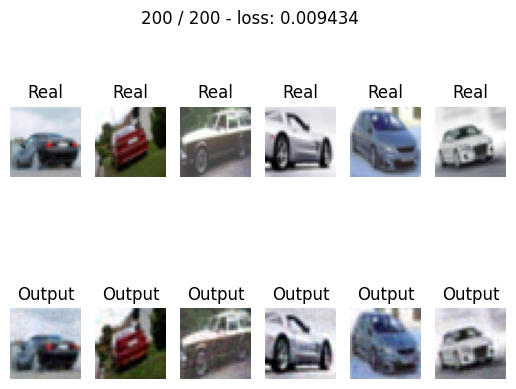

In [8]:
train_loss_history, val_loss_history = train(autoencoder, optimizer, criterion, 200, train_loader)

Отрисую историю ошибки.

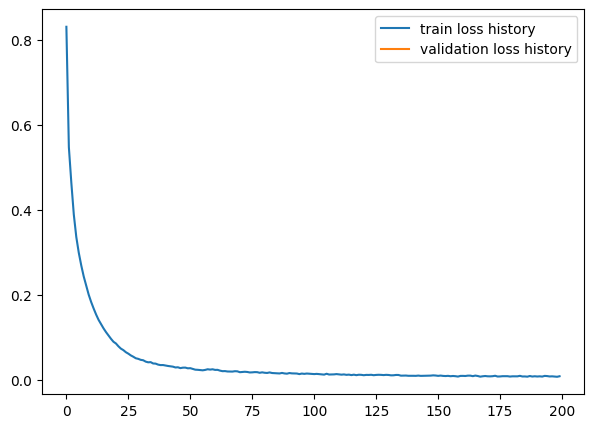

In [9]:
fig,ax = plt.subplots(1,1, sharey=True, figsize=(7,5))

ax.plot(train_loss_history, label='train loss history')
ax.plot(val_loss_history, label='validation loss history')
plt.legend()
plt.show()

Попробую изменять случайные значения скрытого представления картинки.

In [29]:
sample = next(iter(train_loader))
sample = sample.to(device)

latent_code = autoencoder.encoder(sample)
reconstruction = autoencoder.decoder(latent_code)

random_features = np.random.randint(dim_code, size=2)
shifts = np.linspace(-100, 100, num=9)
sample = plain_to_image(sample)
latent_code[0, random_features]

tensor([57.9186, 73.2407], device='cuda:0', grad_fn=<IndexBackward0>)

Взгляну на результаты.

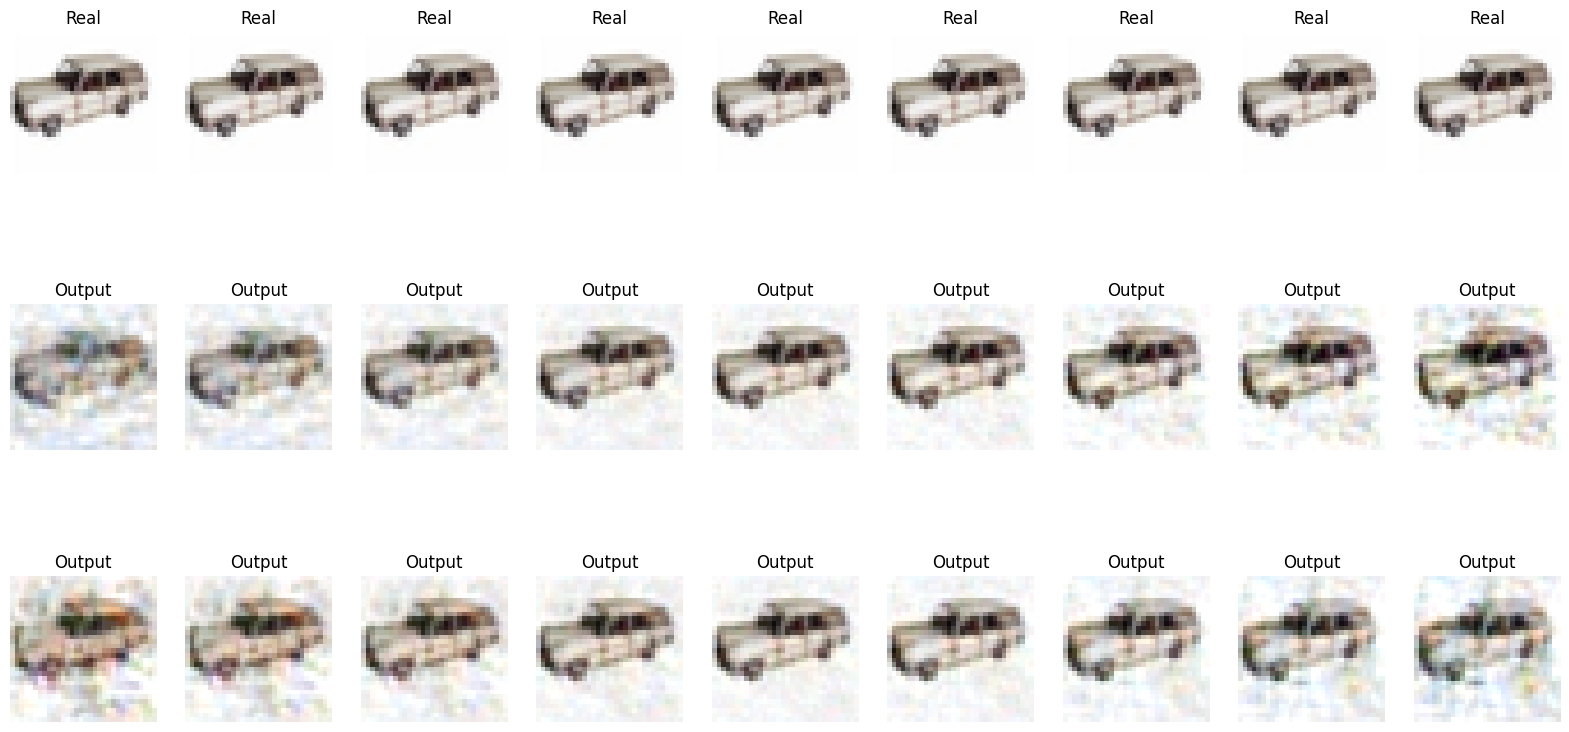

In [30]:
id = 2

plt.figure(figsize=(20,10))
for k in range(9):

    plt.subplot(3, 9, k+1)
    plt.imshow(np.rollaxis(sample[id].cpu().numpy(), 0, 3))
    plt.title('Real')
    plt.axis('off')

    cur_latent_code = latent_code.clone()
    cur_latent_code[id, random_features[0]] += shifts[k]

    cur_reconstruction = autoencoder.decoder(cur_latent_code)
    cur_reconstruction = cur_reconstruction.cpu().detach().numpy()
    cur_reconstruction = plain_to_image(cur_reconstruction)

    plt.subplot(3, 9, k+10)
    plt.imshow(np.rollaxis(np.clip(cur_reconstruction[id], 0, 1), 0, 3))
    plt.title('Output')
    plt.axis('off')

    cur_latent_code = latent_code.clone()
    cur_latent_code[id, random_features[1]] += shifts[k]

    cur_reconstruction = autoencoder.decoder(cur_latent_code)
    cur_reconstruction = cur_reconstruction.cpu().detach().numpy()
    cur_reconstruction = plain_to_image(cur_reconstruction)

    plt.subplot(3, 9, k+19)
    plt.imshow(np.rollaxis(np.clip(cur_reconstruction[id], 0, 1), 0, 3))
    plt.title('Output')
    plt.axis('off')
plt.show()

__Вывод__: В ходе выполнения работы был реализован автоэнкодер для изображения 32 на 32 пикселя. Модель была обучена на изображениях автомобилей. Восстановленные картинки не идеально совпадают с оригиналами, но в целом очень похожи. Изменение случайных значений в векторе скрытого представления изменяет результат восстановления, но какого-то смысла каждое, отдельно взятое значение вектора смысла не несет, хоть в совокупности формирует нейки набор признаков.